In [1]:
from rs_graph.bin.modeling import _create_dataset_for_document_repository_training

data = _create_dataset_for_document_repository_training(prod=True)

data.sample(3)

/Users/evamaxfield/micromamba/envs/rs-graph/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,dataset_source,document_id,document_doi,document_title,document_abstract,document_publication_date,document_contributor_names,repository_id,repository_name,repository_readme,repository_description,repository_creation_date,repository_contributor_usernames,repository_contributor_names,repository_contributor_emails,match
10262,1,9275,10.48550/arxiv.2308.13798,DM-VTON: Distilled Mobile Real-time Virtual Tr...,The fashion e-commerce industry has witnessed ...,2023-01-01,"Trung-Nghia Le, Khoi-Nguyen Nguyen-Ngoc, Thanh...",8949,dm-vton,\n# DM-VTON: Distilled Mobile Real-time Virtua...,👗 DM-VTON: Distilled Mobile Real-time Virtual ...,2023-01-16,"ltnghia, zero-nnkn","Trung-Nghia LE, Khoi-Nguyen Nguyen-Ngoc",,match
2013,-1,14760,10.48550/arxiv.2208.03754,Exploring Long- and Short-Range Temporal Infor...,Learned video compression methods have gained ...,2022-01-01,"Zhenzhong Chen, Huairui Wang",4322,non-expansive-odes,# Designing Stable Neural Networks using Conve...,None,2023-06-29,"dependabot[bot], fsherry",Ferdia,,no-match
26967,-1,6345,10.48550/arxiv.2103.00492,RoBERTa-wwm-ext Fine-Tuning for Chinese Text C...,Bidirectional Encoder Representations from Tra...,2021-01-01,Zhuo Xu,14193,rare-disease-identification,# Rare-disease-identification\n\nThis reposito...,Rare disease identification from free-text cli...,2021-04-13,,,,no-match


In [2]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from scipy.stats import zscore

# for each row, we want the following features:
# text embedding of the document title and abstract (joined together)
# text embedding of the contributor comparisons
# and difference in publication and repository creation date

doc_meta_template = """
Title: {doc_title}
Abstract: {doc_abstract}
""".strip()

repo_meta_template = """
Repository Details:

Name: {repo_name}
README: {repo_readme}
Description: {repo_description}
""".strip()

doc_contributor_template = """
Document Contributors:

Names: {doc_contributor_names}
""".strip()

repo_contributor_template = """
Repository Contributors:

Usernames: {repo_contributor_usernames}
Names: {repo_contributor_names}
Emails: {repo_contributor_emails}
""".strip()

doc_meta_templates = [
    doc_meta_template.format(
        doc_title=str(row["document_title"]),
        doc_abstract=str(row["document_abstract"]),
    )
    for _, row in data.iterrows()
]

repo_meta_templates = [
    repo_meta_template.format(
        repo_name=str(row["repository_name"]),
        repo_readme=str(row["repository_readme"]),
        repo_description=str(row["repository_description"]),
    )
    for _, row in data.iterrows()
]

doc_contributor_templates = [
    doc_contributor_template.format(
        doc_contributor_names=str(row["document_contributor_names"]),
    )
    for _, row in data.iterrows()
]

repo_contributor_templates = [
    repo_contributor_template.format(
        repo_contributor_usernames=str(row["repository_contributor_usernames"]),
        repo_contributor_names=str(row["repository_contributor_names"]),
        repo_contributor_emails=str(row["repository_contributor_emails"]),
    )
    for _, row in data.iterrows()
]

timedeltas = zscore(
    (
        pd.to_datetime(data["repository_creation_date"])
        - pd.to_datetime(data["document_publication_date"])
    ).dt.days.tolist()
)

In [3]:
embed_model = SentenceTransformer("all-distilroberta-v1")

doc_meta_embeddings = embed_model.encode(doc_meta_templates, show_progress_bar=True)
# Comes back as a 2d numpy array, we want rows with columns of
# "doc_meta_dim_1", "doc_meta_dim_2", ..., "doc_meta_dim_n"
doc_meta_embeddings = pd.DataFrame(
    doc_meta_embeddings,
    columns=[f"doc_meta_dim_{i}" for i in range(doc_meta_embeddings.shape[1])]
)

repo_meta_embeddings = embed_model.encode(repo_meta_templates, show_progress_bar=True)
# Comes back as a 2d numpy array, we want rows with columns of
# "repo_meta_dim_1", "repo_meta_dim_2", ..., "repo_meta_dim_n"
repo_meta_embeddings = pd.DataFrame(
    repo_meta_embeddings,
    columns=[f"repo_meta_dim_{i}" for i in range(repo_meta_embeddings.shape[1])]
)

doc_contributor_embeddings = embed_model.encode(doc_contributor_templates, show_progress_bar=True)
# Comes back as a 2d numpy array, we want rows with columns of
# "doc_contributor_dim_1", "doc_contributor_dim_2", ..., "doc_contributor_dim_n"
doc_contributor_embeddings = pd.DataFrame(
    doc_contributor_embeddings,
    columns=[f"doc_contributor_dim_{i}" for i in range(doc_contributor_embeddings.shape[1])]
)

repo_contributor_embeddings = embed_model.encode(repo_contributor_templates, show_progress_bar=True)
# Comes back as a 2d numpy array, we want rows with columns of
# "repo_contributor_dim_1", "repo_contributor_dim_2", ..., "repo_contributor_dim_n"
repo_contributor_embeddings = pd.DataFrame(
    repo_contributor_embeddings,
    columns=[f"repo_contributor_dim_{i}" for i in range(repo_contributor_embeddings.shape[1])]
)

# Concat all embeddings / features into a single df
features = pd.concat(
    [
        doc_meta_embeddings,
        repo_meta_embeddings,
        doc_contributor_embeddings,
        repo_contributor_embeddings,
        pd.DataFrame({"repo_creation_to_publication_date_delta_days": timedeltas}),
        pd.DataFrame({"label": data["match"]})
    ],
    axis=1,
)

features.sample(3)

Batches: 100%|██████████| 1435/1435 [02:55<00:00,  8.17it/s]


,doc_meta_dim_0,doc_meta_dim_1,doc_meta_dim_2,doc_meta_dim_3,doc_meta_dim_4,doc_meta_dim_5,doc_meta_dim_6,doc_meta_dim_7,doc_meta_dim_8,doc_meta_dim_9,...,repo_contributor_dim_760,repo_contributor_dim_761,repo_contributor_dim_762,repo_contributor_dim_763,repo_contributor_dim_764,repo_contributor_dim_765,repo_contributor_dim_766,repo_contributor_dim_767,repo_creation_to_publication_date_delta_days,label
30426,0.022868,-0.033406,0.012748,0.002094,0.025358,0.000662,0.001106,0.018189,-0.017508,0.028799,...,0.009654,0.031241,0.036904,-0.024605,0.099215,0.005132,-0.007089,0.026423,0.202822,match
45215,0.027985,0.006002,-0.014340,-0.032055,-0.049751,0.073310,0.016049,0.025164,0.042706,0.015461,...,-0.030410,0.018563,0.038620,-0.024648,0.062589,-0.013352,0.000972,0.004806,-0.285307,match
35490,0.039057,-0.041532,-0.018817,-0.033888,-0.043945,0.005635,0.003484,0.037207,0.004194,-0.005653,...,-0.004807,-0.006712,0.032846,-0.027130,0.084617,-0.027134,0.011281,0.013023,3.186646,no-match


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(
    hidden_layer_sizes=(100, 100, 100),
    learning_rate="adaptive",
    random_state=42,
    max_iter=200,
    verbose=10,
)

train_df, test_df = train_test_split(
    features,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=features["label"],
)

clf.fit(
    train_df.drop(columns=["label"]),
    train_df["label"]
)

Iteration 1, loss = 0.46091637
Iteration 2, loss = 0.23651876
Iteration 3, loss = 0.16938529
Iteration 4, loss = 0.12651262
Iteration 5, loss = 0.10135876
Iteration 6, loss = 0.06813337
Iteration 7, loss = 0.05786664
Iteration 8, loss = 0.04976371
Iteration 9, loss = 0.03174686
Iteration 10, loss = 0.02419226
Iteration 11, loss = 0.02894755
Iteration 12, loss = 0.02517568
Iteration 13, loss = 0.01670240
Iteration 14, loss = 0.01416614
Iteration 15, loss = 0.02028494
Iteration 16, loss = 0.02033228
Iteration 17, loss = 0.01587310
Iteration 18, loss = 0.01451435
Iteration 19, loss = 0.01463829
Iteration 20, loss = 0.01185312
Iteration 21, loss = 0.01194835
Iteration 22, loss = 0.02324482
Iteration 23, loss = 0.01493429
Iteration 24, loss = 0.00891956
Iteration 25, loss = 0.00578030
Iteration 26, loss = 0.00490587
Iteration 27, loss = 0.01288691
Iteration 28, loss = 0.01974530
Iteration 29, loss = 0.02500946
Iteration 30, loss = 0.00434053
Iteration 31, loss = 0.00148761
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(100, 100, 100), learning_rate='adaptive',
              random_state=42, verbose=10)

In [5]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay

test_preds = clf.predict(test_df.drop(columns=["label"]))

accuracy = accuracy_score(test_df["label"], test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    test_df["label"],
    test_preds,
    average="binary",
    pos_label="match",
)
accuracy, precision, recall, f1

(0.9319023752451514, 0.9266035299182093, 0.9381128786227937, 0.932322685435842)

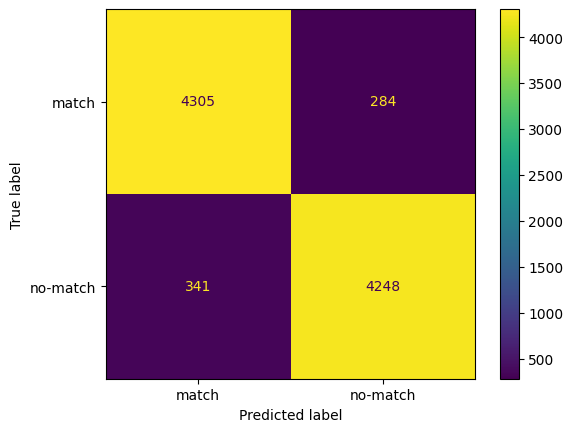

In [6]:
ConfusionMatrixDisplay.from_predictions(
    test_df["label"],
    test_preds,
)

In [7]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(
    hidden_layer_sizes=(300, 300),
    learning_rate="adaptive",
    random_state=42,
    verbose=10,
    n_iter_no_change=3,
    early_stopping=True,
    tol=1e-4,
)

mlp_clf.fit(
    train_df.drop(columns=["label"]),
    train_df["label"]
)

mlp_test_preds = mlp_clf.predict(test_df.drop(columns=["label"]))
mlp_accuracy = accuracy_score(test_df["label"], mlp_test_preds)
mlp_precision, mlp_recall, mlp_f1, _ = precision_recall_fscore_support(
    test_df["label"],
    mlp_test_preds,
    average="binary",
    pos_label="match",
)

mlp_accuracy, mlp_precision, mlp_recall, mlp_f1

Iteration 1, loss = 0.44700521
Validation score: 0.875545
Iteration 2, loss = 0.22509611
Validation score: 0.881536
Iteration 3, loss = 0.14847019
Validation score: 0.919662
Iteration 4, loss = 0.10735352
Validation score: 0.925926
Iteration 5, loss = 0.07386109
Validation score: 0.920479
Iteration 6, loss = 0.05154267
Validation score: 0.923475
Iteration 7, loss = 0.03591464
Validation score: 0.935185
Iteration 8, loss = 0.02186270
Validation score: 0.901961
Iteration 9, loss = 0.01548564
Validation score: 0.936819
Iteration 10, loss = 0.00615363
Validation score: 0.932462
Iteration 11, loss = 0.00335670
Validation score: 0.937908
Iteration 12, loss = 0.00158712
Validation score: 0.941176
Iteration 13, loss = 0.00107903
Validation score: 0.940632
Iteration 14, loss = 0.00093608
Validation score: 0.942266
Iteration 15, loss = 0.00083463
Validation score: 0.941176
Iteration 16, loss = 0.00077065
Validation score: 0.940904
Iteration 17, loss = 0.00072288
Validation score: 0.940632
Iterat

(0.944214425800828, 0.9265536723163842, 0.964916103726302, 0.9453458582408197)

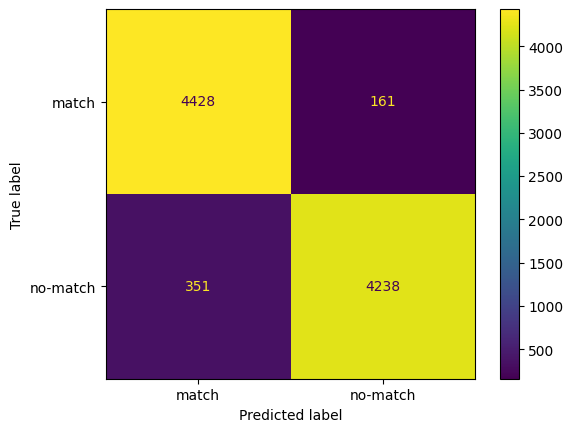

In [8]:
ConfusionMatrixDisplay.from_predictions(
    test_df["label"],
    mlp_test_preds,
)